# Dominance and satisfaction anlysis (AKA filters)

Se ejemplifica a continuación un ejemplo práctico de como filtrar alternativas
que sean dominadas, o que 


## Conceptual overview

A fin de decidir comprar una serie de bonos, una empresa estudió cinco 
inversiones candidatas: *PE*, *JN*, *AA*, *FX*, *MM* y *GN*. 
El departamento de finanzas decide considerar los siguientes criterios para la 
selección:

1. **ROE:** Rendimiento porcentual por cada peso invertido. Sentido de optimidad, $Maximize$.
2. **CAP:** Años de capitalización en el mercado. Sentido de optimidad, $Maximize$.  
3. **RI:** Puntos de riesgo del título valor. Sentido de optimidad, $Minimize$. 

The full decision matrix

In [1]:
import skcriteria as skc

dm = skc.mkdm(
    matrix=[
        [7, 5, 35],
        [5, 4, 26],
        [5, 6, 28],
        [3, 4, 36],
        [1, 7, 30],
        [5, 8, 30],
    ],
    objectives=[max, max, min],
    alternatives=["PE", "JN", "AA", "FX", "MM", "FN"],
    criteria=["ROE", "CAP", "RI"],
)

dm

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
JN          5          4        26
AA          5          6        28
FX          3          4        36
MM          1          7        30
FN          5          8        30
[6 Alternatives x 3 Criteria]

## Satisfaction analysis

Es razonable pensar que cualquier decisor quiera fijar  “umbrales de 
satisfacción” para cada criterio, de manera tal 
que se eliminen las alternativas que en algún criterio no los superan.

La idea básica fue propuesta en el trabajo 
"_A Behavioral Model of Rational Choice_" 
<cite data-cite="simon1955behavioral">[simon1955behavioral]</cite>, que habla 
de  “*niveles de aspiración*”  y son fijados a priori por el decisor.

> Para nuestro ejemplo supondremos que el decisor solo se acepta alternativas 
> que rindan al menos el 2%

Por esto vamos a necesitar el modulo `filters`.

In [2]:
from skcriteria.preprocessing import filters

Los filtros operan de la siguiente manera:

- Al momento de contrucción se les probee de un dict que como llave tiene
  el nombre de un criterio, y como valor la condiccion que debe satisfacer
  el criterio para no ser elmiminaado.
- Opcionalmente recibe un parametro `ignore_missing_criteria` el cual si esta
  en False (valor por defecto) hace fallar cualquier intento de transformacion
  de una matriz que no tenga alguno de los criterios .
- Para que una alternativa no sea eliminada la alternativa tiene que pasar 
  todas las condiciones del filtro.

El filtro mas simple, consiste los objetos de la clase ``filters.Filter``
los cuales como valor del map a satisfacer, reciben una funcion que recibe
como parámetro el criterio a evaluar y retorna una mascara con valores `True`
para los criterios que queremos mantener.

Para escribir la funcion que filtre *ROE* para si su valor es >= que 2%.

In [3]:
def roe_filter(v):
    return v >= 2  # como v es un numpy array esto es bastante corto

Ahora si queremos incorporarlo al filtro, el código quedaria de la siguiente
forma

In [4]:
flt =  filters.Filter({"ROE": roe_filter})
flt

Filter(criteria_filters={'ROE': <function roe_filter at 0x7fd27f958dc0>}, ignore_missing_criteria=False)

De todas formas `scikit-criteria` ofrece una coleccion de filtros mas simple
que implementas las operaciones mas comunes de igualdad, desigualdad
e inclusion en un conjunto.

En nuestro claso estamos interesados en la clase `FilterGE`, donde GE significa
*Greater or Equal*.

Asi el filtro quedaria definido como

In [5]:
flt = filters.FilterGE({"ROE": 2})
flt

FilterGE(criteria_filters={'ROE': 2}, ignore_missing_criteria=False)

La forma de aplicar el filtro a una DecisionMatrix, es como cualquier 
transformador: utilizando el metodo transform:

In [6]:
dmf = flt.transform(dm)
dmf

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
JN          5          4        26
AA          5          6        28
FX          3          4        36
FN          5          8        30
[5 Alternatives x 3 Criteria]

Como se puede, verse se elimino la alternativa `MM` la cual no cumplia con un
$ROE >= 2$.

Si por otro lado (por poner un ejemplo) quisieramos  filtrar las alternativas
$ROE > 3$ y $CAP > 4$ (utilizando la matriz original), podemos utilizar
el filtro `FilterGT` donde GT es *Greater Than*.

In [7]:
filters.FilterGT({"ROE": 3, "CAP": 4}).transform(dm)

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
AA          5          6        28
FN          5          8        30
[3 Alternatives x 3 Criteria]

<div class="alert alert-info">
**Note:** 

Si es necesario filtrar las alternativas por dos condiciones separadas 
puede utilizarse un pipeline. Un ejemplo de esto podemos verlo mas adelante.
</div>

El listado completo de filtros implementados, por Scikit-Criteria es:

- ``filters.Filter``: Filter alternatives according to the value of a criterion 
  using arbitrary functions.

  ```python
  filters.Filter({"criterion": lambda v: v > 1})
  ```

- ``filters.FilterGT``: Filter Greater Than ($>$).
  
  ```python
  filters.FilterGT({"criterion":  1})
  ```

- ``filters.FilterGE``: Filter Greater or Equal than ($>=$).

  ```python
  filters.FilterGE({"criterion":  2})
  ```

- ``filters.FilterLT``: Filter Less Than ($<$).
  
  ```python
  filters.FilterLT({"criterion":  1})
  ```

- ``filters.FilterLE``: Filter Less or Equal than ($<=$).

  ```python
  filters.FilterLE({"criterion":  2})
  ```

- ``filters.FilterEQ``: Filter Equal ($==$).
  
  ```python
  filters.FilterEQ({"criterion":  1})
  ```

- ``filters.FilterNE``: Filter Not-Equal than ($!=$).

  ```python
  filters.FilterNE({"criterion":  2})
  ```

- ``filters.FilterIn``: Filter if the values is in a set ($\in$).
  
  ```python
  filters.FilterIn({"criterion":  [1, 2, 3]})
  ```

- ``filters.FilterNotIn``: Filter if the values is not in a set ($\notin$).

  ```python
  filters.FilterNotIn({"criterion":  [1, 2, 3]})
  ```


## Dominance

Se dice que que una alternativa $A_0$ domina a una alternativa $A_1$ 
($A_0 \succeq A_1$),  si $A_0$ es igual en todos los criterios y mejor en 
almenos un criterio. Por otro lado, se dice que  $A_0$ domina estrictiamente 
$A_1$ ($A_0 \succ A_1$),  si $A_0$ es mejor en todos los criterios que $A_1$.

Bajo este mismo tren de pnesamiento, se denomina *alternativa dominante*  
a una alternativa que domina a todas las demas.

Si existe una alternativa dominante es sin duda la mejor elección. Si no se 
quiere de una ordenación consignada, ya se tiene la solución del problema. 

Por otro lado, una *alternativa es dominada* si existe al menos otra alternativa
que la domina. Si existe una alternativa dominada y no se quiere una ordenación 
consignada, debe ser apartada del conjunto de alternativas de decisión. 

Generalmente sólo  las alternativas no-dominadas o eficientes son las que interesan.

### Scikit-Criteria dominance analysis

Scikit-criteria, contiene una serie de herramientas dentro del atributo,
`dominance` de decision matrix, útil para la evaluacion de alternativas
dominantes y dominadas.

Por ejemplo podemos acceder a todas las alternativas dominadas utilizando
el ḿetodo `dominated`

In [10]:
dmf.dominance.dominated()

PE    False
JN    False
AA    False
FX     True
FN    False
dtype: bool

Se puede ver con esto, que `FX` es una alternativa, dominada. Si por otro
lafo queremos saber cuales son las alternativas *estrictamente dominadas* 
se realizando proveyendo el parámetro `strict`al método

In [13]:
dmf.dominance.dominated(strict=True)

PE    False
JN    False
AA    False
FX     True
FN    False
dtype: bool

Puede verse que FX es estrictamente dominado por almenos otra alternativa.

Si quisieramos averiguar cuales son las alternativas dominantes de  *FX*, 
podemos optar por dos caminos: 

1. Listar todas las alternativas dominantes/estrictamente dominantes de 
2. *FX* utiizatilizando `dominator_of()`.

In [24]:
dmf.dominance.dominators_of("FX", strict=True)

array(['PE', 'AA', 'FN'], dtype=object)

2. Utilizar `dominance()`/`dominance.dominance()` para ver la relación completa
   de dominancia entre todas alternativas. 

In [26]:
dmf.dominance(strict=True)  # equivalent to dmf.dominance.dominance()

,PE,JN,AA,FX,FN
PE,False,False,False,True,False
JN,False,False,False,False,False
AA,False,False,False,True,False
FX,False,False,False,False,False
FN,False,False,False,True,False


En este caso lo que se observa es que alternativa Fila domina a que alternativa
columna.

Podemos estudiar esta matriz en forma de heamap usando, por ejemplo, la 
libreria  [seaborn](http://seaborn.pydata.org/)

<AxesSubplot:>

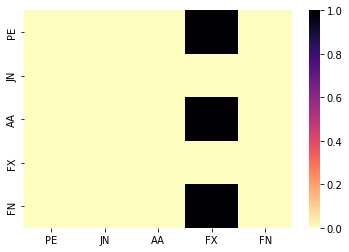

In [42]:
import seaborn as sns
sns.heatmap(dmf.dominance.dominance(strict=True), cmap="magma_r")

Finalmente podemos ver como se relacionan cada una de las alternativas 
dominatnes con *FX* utilizando `compare()`

In [37]:
for dominant in dmf.dominance.dominators_of("FX"):
    display(dmf.dominance.compare(dominant, 'FX'))

Criteria               Performance
                     ROE    CAP     RI            
Alternatives PE     True   True   True           3
             FX    False  False  False           0
Equals             False  False  False           0

Criteria               Performance
                     ROE    CAP     RI            
Alternatives JN     True  False   True           2
             FX    False  False  False           0
Equals             False   True  False           1

Criteria               Performance
                     ROE    CAP     RI            
Alternatives AA     True   True   True           3
             FX    False  False  False           0
Equals             False  False  False           0

Criteria               Performance
                     ROE    CAP     RI            
Alternatives FN     True   True   True           3
             FX    False  False  False           0
Equals             False  False  False           0

### Filter non-dominated alternatives

Finalmente skcriteria ofrece una forma de filtar alternativas non-dominadas,
la cual acepta como parametro si quiere evaluar la dominancia estrictca.

In [43]:
flt = filters.FilterNonDominated(strict=True)
flt

FilterNonDominated(strict=True)

In [44]:
flt.transform(dmf)

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
JN          5          4        26
AA          5          6        28
FN          5          8        30
[4 Alternatives x 3 Criteria]

## Full expermient

Podemos finalmente crear un experimento completo de MCDA que tome en cuenta
las en análisis de satisfaccion y dominancia.

El expeimento completo tendria las siguientes etapas

1. Se eliminan alternativas que no que rindan al menos el 2% ($ROE >= 2$).
2. Se eliminan alternativas dominadas.
3. Se convierten todos los criterios a maximizar.
4. Se excala los pesos por la suma todal.
5. Se escala la matriz por el modulo del vecto.
6. Se aplica [TOPSIS]()

Para esto lo mas conveniente es utilizar un pipeline

In [49]:
from skcriteria.preprocessing import scalers, invert_objectives
from skcriteria.madm.similarity import TOPSIS
from skcriteria.pipeline import mkpipe

pipe = mkpipe(
    filters.FilterGE({"ROE": 2}),
    filters.FilterNonDominated(strict=True),
    invert_objectives.MinimizeToMaximize(),
    scalers.SumScaler(target="weights"),
    scalers.VectorScaler(target="matrix"),
    TOPSIS(),
)

pipe

SKCPipeline(steps=[('filterge', FilterGE(criteria_filters={'ROE': 2}, ignore_missing_criteria=False)), ('filternondominated', FilterNonDominated(strict=True)), ('minimizetomaximize', MinimizeToMaximize()), ('sumscaler', SumScaler(target='weights')), ('vectorscaler', VectorScaler(target='matrix')), ('topsis', TOPSIS(metric='euclidean'))])

Ahora aplicamos el pipeline a los datos originales

In [51]:
pipe.evaluate(dm)

,PE,JN,AA,FN
Rank,3,4,2,1


----

In [ ]:
import datetime as dt
import skcriteria

print("Scikit-Criteria version:", skcriteria.VERSION)
print("Running datetime:", dt.datetime.now())